# Inspecting atlas shipped in BrainLM

The original data processing code of BrainLM extract time sereis using A424 atlas in an unidentified MNI152 template in 2mm space. 

There were no sainty check to make sure all the functional data and the atlas are in the same space.
Hence for the purpose of running the BrainLM tutorial using the nilearn test dataset developmental dataset, and using as much of the original code as possible, we need to manually resample the atlas to match the nilearn developmental dataset.

In [10]:
from nilearn import plotting, image
from nilearn.maskers import NiftiLabelsMasker, NiftiSpheresMasker, NiftiMasker
from nilearn.datasets import MNI152_FILE_PATH, fetch_development_fmri,fetch_icbm152_2009
import matplotlib.pyplot as plt
from importlib.resources import files
from nilearn._utils import check_niimg
import numpy as np
from hfplayground.data import downsample_for_tutorial

from datasets import load_from_disk


In [11]:
downsample_atlas = downsample_for_tutorial(files('hfplayground') / 'data/brainlm/atlases/A424+2mm.nii.gz', '/tmp/')
downsample_mni = downsample_for_tutorial(MNI152_FILE_PATH, '/tmp/')

The original A424 atlas is very strictly following the grey matter, and includes the cerebellum. 

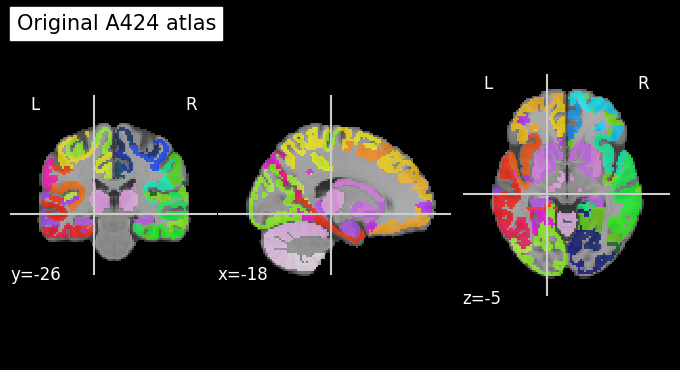

In [12]:
plotting.plot_roi(files('hfplayground') / 'data/brainlm/atlases/A424+2mm.nii.gz', title="Original A424 atlas", black_bg=True)

The nilearn test dataset has been downsampled to voxel size 4mm^3, so we have to resample the atlas accordingly. 

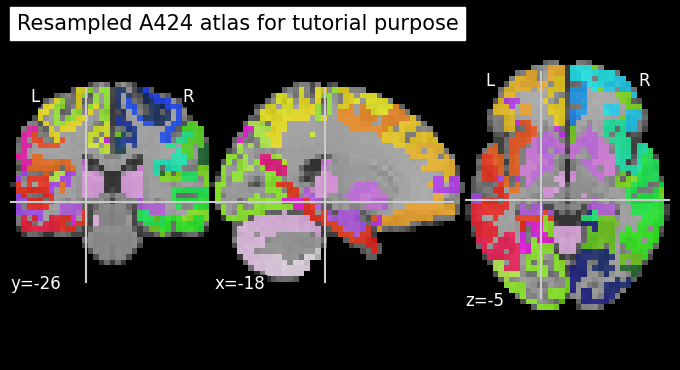

In [13]:
plotting.plot_roi(downsample_atlas, downsample_mni, title="Resampled A424 atlas for tutorial purpose")

Let's overlay it on real data. 

We can see that the cerebellum is cut off in the EPI scan. This is a very common compromise. 

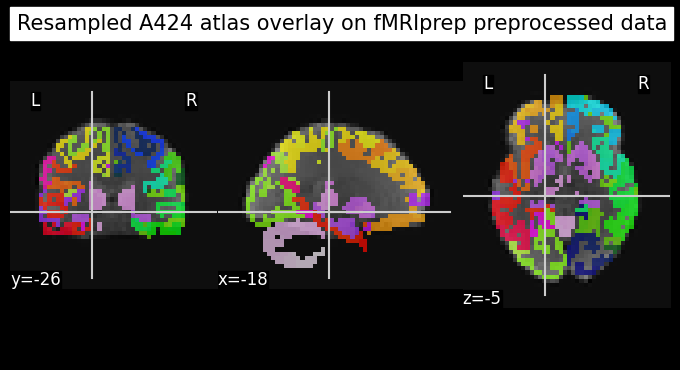

In [14]:
bg_img = image.load_img('../data/external/development_fmri/development_fmri/sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')
plotting.plot_roi(downsample_atlas, bg_img=bg_img.slicer[..., 0], title="Resampled A424 atlas overlay on fMRIprep preprocessed data")

Overlaying on data after denoising. Since I used a MNI template brain mask, we can see the missing cerebellum is filled up. 

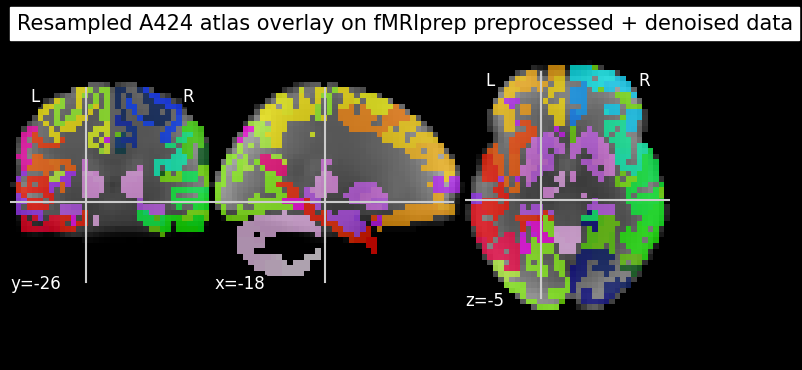

In [15]:
bg_img = image.load_img('../data/interim/development_fmri/sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preprocSimple+gsrFwhm8mm_bold.nii.gz')
plotting.plot_roi(downsample_atlas, bg_img=bg_img.slicer[..., 0], title="Resampled A424 atlas overlay on fMRIprep preprocessed + denoised data")

Once we have some preprocessed time series, using their workflow, let's have a look at the results.

The fMRIPrep data here is preprocessed with FWHM 8mm, standardization at per voxel level, and denoise with the simple strategy of load_confounds, with cosine regressors, 6 motion parameters, white matter/csf followed by some very sus workflow provided with the code to extract time sereis from the ROIs.

These outputs are hugging face / arrow datasets. For the brain region coordinates, each entry is a brain region with it's index, and corrdinate of the centroid.

For the time series data, each subject is an entry:
- Raw_Recording: number of ROI, number of time points
- Voxelwise_RobustScaler_Normalized_Recording: number of time points, number of ROI
- All_Patient_All_Voxel_Normalized_Recording: number of ROI, number of time points
- Per_Patient_All_Voxel_Normalized_Recording: number of ROI, number of time points
- **Per_Patient_Per_Voxel_Normalized_Recording**: number of ROI, number of time points - this is used in BrainLM training
- Per_Voxel_All_Patient_Normalized_Recording: number of ROI, number of time points
- Subtract_Mean_Normalized_Recording: number of ROI, number of time points 
- Subtract_Mean_Divide_Global_STD_Normalized_Recording: number of ROI, number of time points 
- Subtract_Mean_Divide_Global_99thPercent_Normalized_Recording: number of ROI, number of time points 
- Filename: just file name
- Patient ID: totally failed at parsing this, no value

I am going to use seed base connectivity using the PCC as a way to do some sanity check.

In [ ]:
from datasets import load_from_disk

coords_ds = load_from_disk("../data/processed/brainlm_a424/Brain_Region_Coordinates")
train_ds = load_from_disk("../data/processed/brainlm_a424/train")

Manually found a PCC ish coordinate.

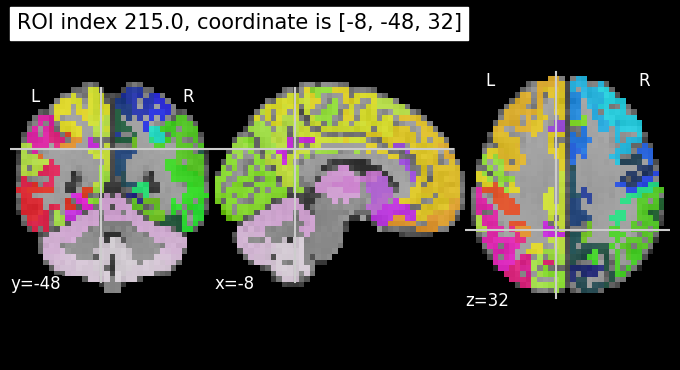

In [17]:
roi_index = 215  # this is index saved in file, so 1-based
coord = [int(coords_ds[roi_index - 1][k]) for i, k in enumerate(coords_ds[roi_index - 1]) if i != 0]
plotting.plot_roi(
    downsample_atlas, 
    bg_img=downsample_mni, 
    title=f"ROI index {coords_ds[roi_index - 1]['Index']}, coordinate is {coord}", 
    cut_coords=coord)

Create seed base connectivity map as a base of comparison for all scaled data by BrainLM workflow.

[get_dataset_dir] Dataset found in /home/hwang/nilearn_data/icbm152_2009


/home/hwang/simexp/hwang/hfplayground/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/hwang/simexp/hwang/hfplayground/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/hwang/simexp/hwang/hfplayground/.venv/lib/python3.12/site-packages/nilearn/plotting/img_plotting.py:232: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  data = safe_get_data(img, ensure_finite=True)


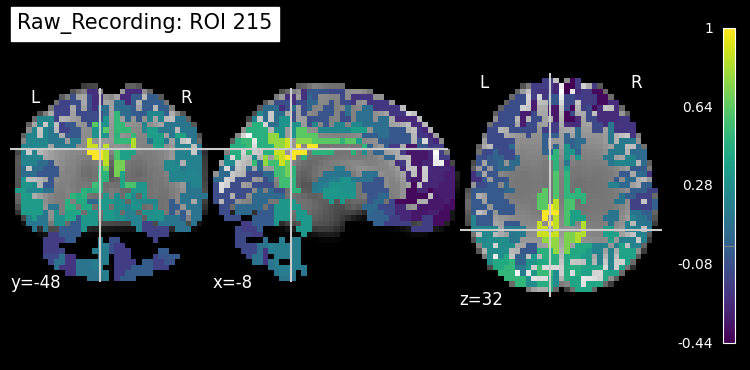

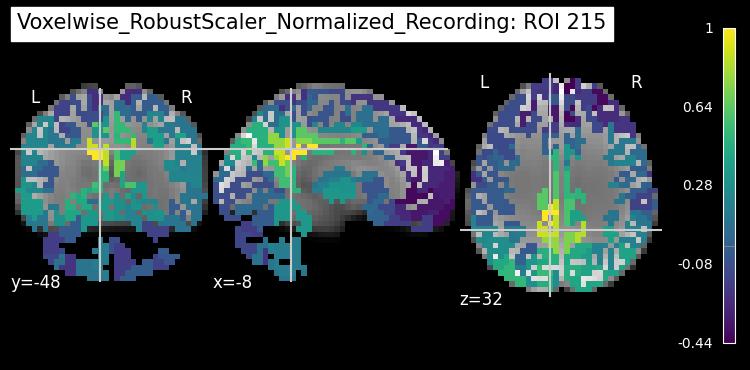

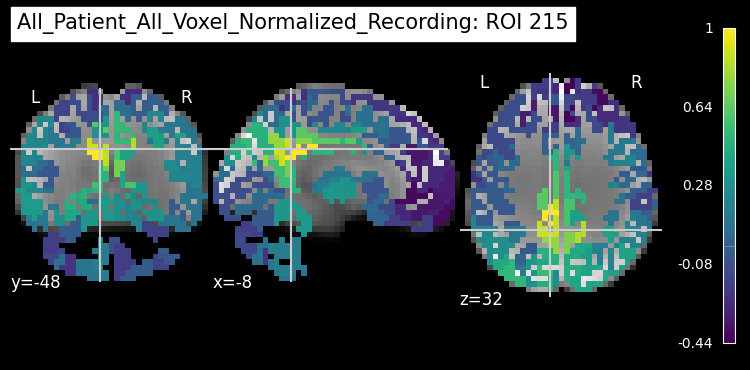

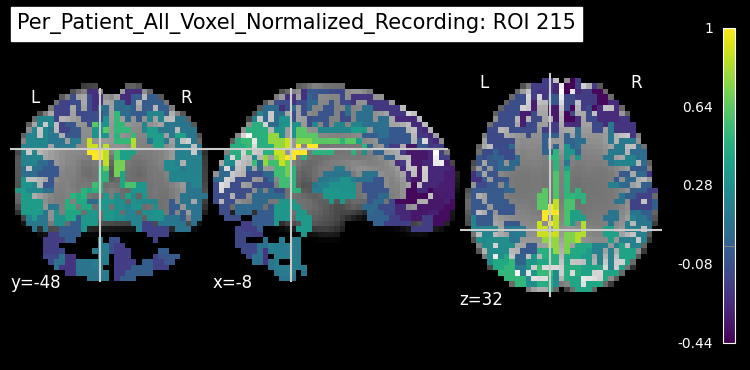

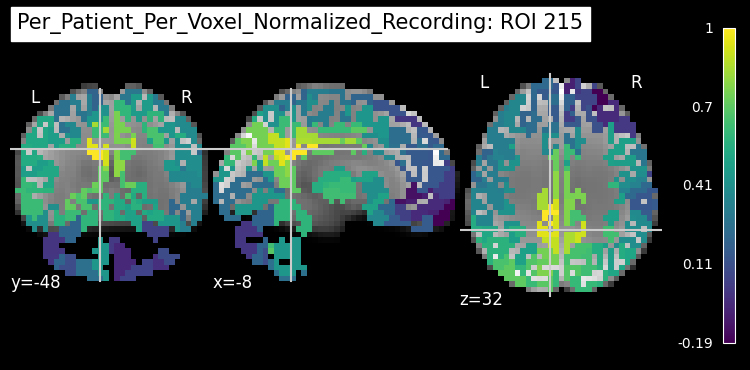

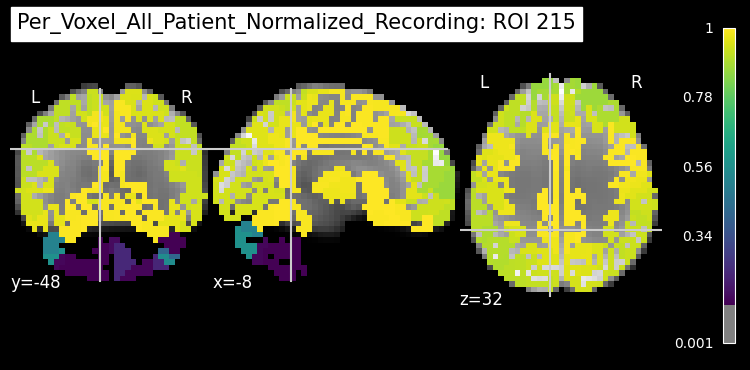

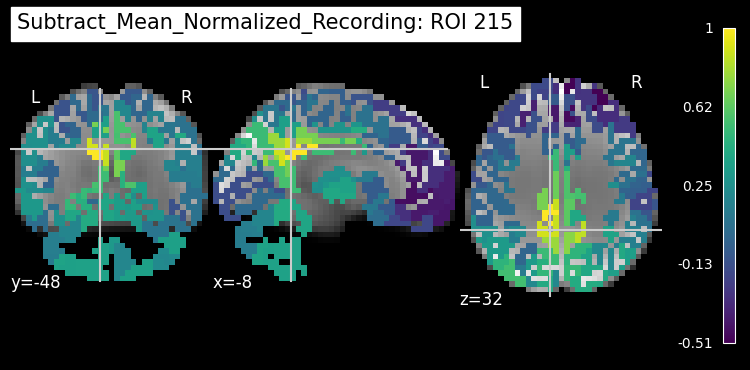

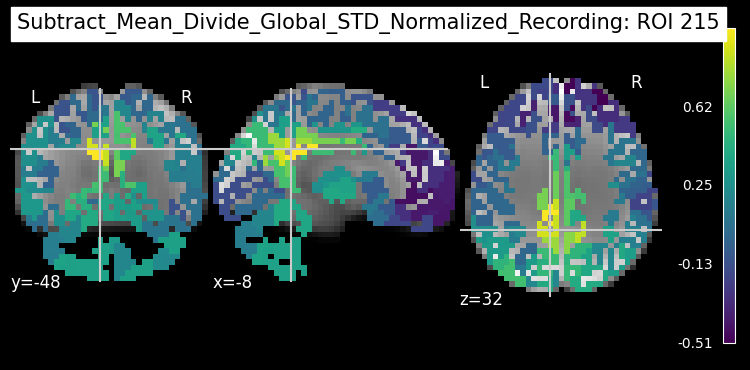

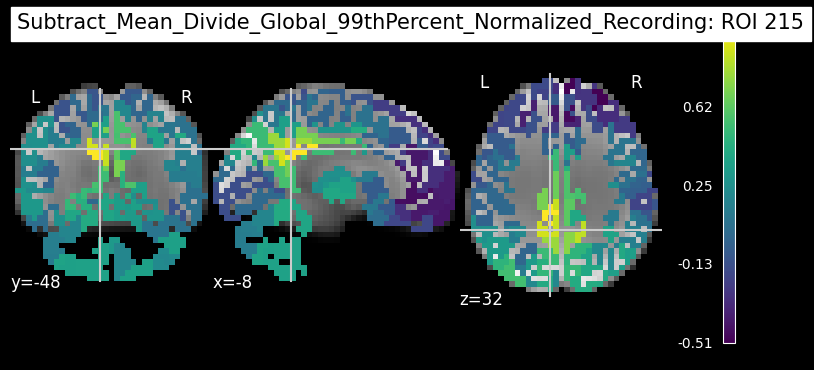

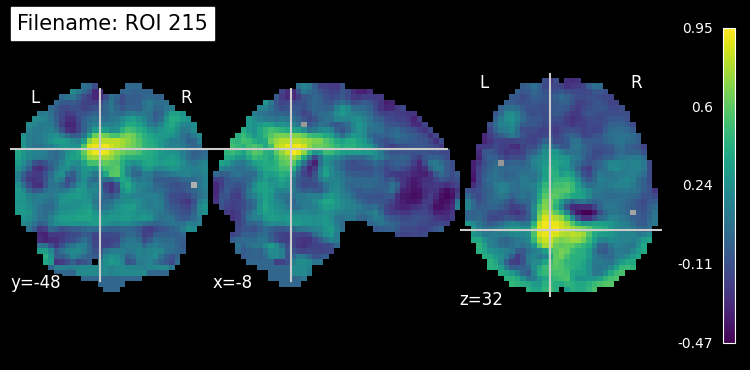

In [18]:
get_seed = NiftiSpheresMasker(seeds=[coord], radius=8).fit()
mni_mask = fetch_icbm152_2009()['mask']
mni_mask = downsample_for_tutorial(mni_mask, '/tmp/')
mni_masker = NiftiMasker(mni_mask).fit()
atlas_masker = NiftiLabelsMasker(downsample_atlas).fit()

for key in train_ds[0].keys():
    if "Recording" not in key:
        if key == 'Filename':
            filename = train_ds[0]['Filename'].replace('.dat', '.nii.gz')
            nii_path = f"../data/interim/development_fmri/{filename}"
            ts = get_seed.transform(nii_path)
            voxels = mni_masker.transform(nii_path)
            seed_base_connectivity = np.corrcoef(ts.T, voxels.T)[1:, 0]
            nii = mni_masker.inverse_transform(seed_base_connectivity)
        else:    
            continue
    else:
        if key == 'Voxelwise_RobustScaler_Normalized_Recording':
            seed_base_connectivity = np.corrcoef(np.array(train_ds[0][key]).T)[roi_index - 1]
        else:
            seed_base_connectivity = np.corrcoef(np.array(train_ds[0][key]))[roi_index - 1]
        nii = atlas_masker.inverse_transform(seed_base_connectivity)
    plotting.plot_img(nii, threshold=0.001, cut_coords=coord, bg_img=bg_img.slicer[..., 0], black_bg=True, colorbar=True,
    title=f"{key}: ROI {roi_index}")

# Conclusion

The various scaling done in the BrainLM workflow will produce drasically different results if the preprocessed data did not have any kind of scaling per voxel.